In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.ops import roi_pool
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.transforms.functional import to_tensor
from torchvision.io import read_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Faster R-CNN

## from scratch

In [2]:
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        resnet = resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        return self.features(x)

class RPN(nn.Module):
    def __init__(self, in_channels, anchor_count=9):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_score = nn.Conv2d(512, anchor_count * 2, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, anchor_count * 4, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        rpn_cls_score = self.cls_score(x)
        rpn_bbox_pred = self.bbox_pred(x)
        return rpn_cls_score, rpn_bbox_pred

class FasterRCNN(nn.Module):
    def __init__(self, class_num):
        super(FasterRCNN, self).__init__()
        self.backbone = Backbone()
        self.rpn = RPN(in_channels=2048)
        self.class_num = class_num
        self.classifier = nn.Linear(2048 * 7 * 7, self.class_num)  # 2048은 Backbone 출력 채널 수

    def forward(self, x, rois):
        features = self.backbone(x)
        rpn_cls_score, rpn_bbox_pred = self.rpn(features)
        pooled_features = roi_pool(features, rois, output_size=(7, 7), spatial_scale=1.0)
        pooled_features_flat = pooled_features.view(pooled_features.size(0), -1)
        class_scores = self.classifier(pooled_features_flat)
        
        return class_scores, rpn_cls_score, rpn_bbox_pred

In [3]:
model = FasterRCNN(100)
x = torch.randn(1, 3, 224, 224)
rois = torch.tensor([[0, 100, 100, 200, 200]], dtype=torch.float32)

class_scores, rpn_cls_score, rpn_bbox_pred = model(x, rois)
print(class_scores.shape, rpn_cls_score.shape, rpn_bbox_pred.shape)  # 최종 클래스 점수의 출력 크기 확인

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.5MB/s]


torch.Size([1, 100]) torch.Size([1, 18, 7, 7]) torch.Size([1, 36, 7, 7])


## Pre-trained Faster RCNN

[Link](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn)
- 입력: [C, H, W] 형태의 텐서 리스트로, 각 이미지는 0에서 1 사이의 범위에 있어야 합니다. 이미지의 크기는 서로 달라도 상관없습니다.

- 훈련 모드와 평가 모드에 따라 동작이 달라집니다.

- `model.train()`

    - input: 입력 텐서와 함께 target(딕셔너리 / 리스트)이 필요:

        - boxes (FloatTensor[N, 4]): [x1, y1, x2, y2] 형식의 target bbox, 0 <= x1 < x2 <= W 및 0 <= y1 < y2 <= H 범위 안에 있어야 함
        
        - labels (Int64Tensor[N]): 각 target bbox에 대한 클래스 레이블

    - return: RPN & R-CNN의 cls/reg loss가 포함된 Dict[Tensor] 반환
    
- `model.eval()`

    - input: 입력 텐서"만" 필요
    
    - return: 입력 텐서에 대한 모델의 prediction이 Dict[Tensor]로 반환
    
        - boxes (FloatTensor[N, 4]): [x1, y1, x2, y2] 형식의 prediction bbox, 0 <= x1 < x2 <= W 및 0 <= y1 < y2 <= H 범위 안에 있어야 함
        
        - labels (Int64Tensor[N]): 각 prediction bbox에 대한 클래스 레이블
        
        - scores (Tensor[N]): 각 prediction의 점수

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import ResNet50_Weights

model = fasterrcnn_resnet50_fpn(
#     pretrained=True,
    weights_backbone=ResNet50_Weights.DEFAULT,
#     weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    
#     num_classes=100 # num_classes를 바꾸고 싶다면 pretrained FPN 사용 불가
    )

# 출력 계층 수정 (num_classes를 2로 변경 - 0: 배경, 1은 자동차)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 23.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### 구조
- Transform
- Backbone(ResNet50)
- RPN
- RoI head

In [5]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [6]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [7]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

# Dataset 살펴보기

In [9]:
train_csv = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
train_csv.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [10]:
len(train_csv)

559

In [11]:
len(train_csv["image"].unique())

355

In [13]:
train_dir = "/kaggle/input/car-object-detection/data/training_images"
test_dir = "/kaggle/input/car-object-detection/data/testing_images"

In [19]:
sorted_df = train_csv.sort_values(by=['image'])
sorted_df.value_counts(subset=['image'])

image          
vid_4_26460.jpg    7
vid_4_6240.jpg     6
vid_4_26440.jpg    5
vid_4_6260.jpg     5
vid_4_26420.jpg    5
                  ..
vid_4_10140.jpg    1
vid_4_1020.jpg     1
vid_4_1040.jpg     1
vid_4_10480.jpg    1
vid_4_10500.jpg    1
Name: count, Length: 355, dtype: int64

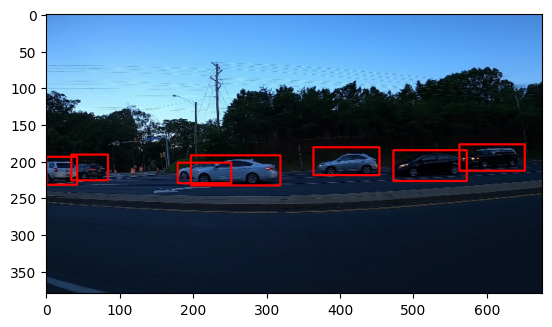

In [22]:
image_path = os.path.join(train_dir, 'vid_4_26460.jpg')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

labels = train_csv[train_csv['image']=='vid_4_26460.jpg']

for row in labels.itertuples():
    xmin, ymin, xmax, ymax = int(row[2]), int(row[3]), int(row[4]), int(row[5])
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
plt.imshow(image)

In [ ]:
class CarDataset(Dataset):
    def __init__(self, df, path):
        super().__init__()
        
    def __len__(self):
        return 

    def __getitem__(self, idx):

        return image, target, image_id